In [1]:
import openslide, pickle, os
import numpy as np
import matplotlib.pyplot as plt

from modules import *

### Name Setting

In [2]:
gdcID = "3c403eb4-8242-4e4e-8a16-7e7935c770a2"

pathWSI = "TCGA-NJ-A4YF-01Z-00-DX1.svs"
pathSpec = "test_spec.tif"
pathAnno = "test_anno.tif"

### Prepare Data

In [3]:
os.system("./gdc-client download %s"%gdcID)
os.system("mv %s/TCGA-NJ-A4YF-01Z-00-DX1.*.svs TCGA-NJ-A4YF-01Z-00-DX1.svs"%gdcID)
os.system("rm -r %s"%gdcID)

100% [############################################] Time:  0:13:56   3.5 MiB/s 
Successfully downloaded: 1


0

In [4]:
handleWSI = openslide.OpenSlide(pathWSI)
coordinates = pickle.load(open("coordinates.dump", "rb"))

### Color Range Selecter

In [5]:
img = np.array(handleWSI.read_region((0, 0), 2, handleWSI.level_dimensions[2]).convert("RGB"))
hsvlDic = CvtHSVLDic(img)

In [6]:
rangeSelectList = [{'h' : (200, 210), 's' : (100, 160), 'v' : (70, 150), 'l' : (50, 255)},
                   {'h' : (210, 240), 's' : (50, 160), 'v' : (150, 220), 'l' : (50, 255)}]
gauthSelect = {"gX" : 31,"gS" : 21, "th" : 0.06}

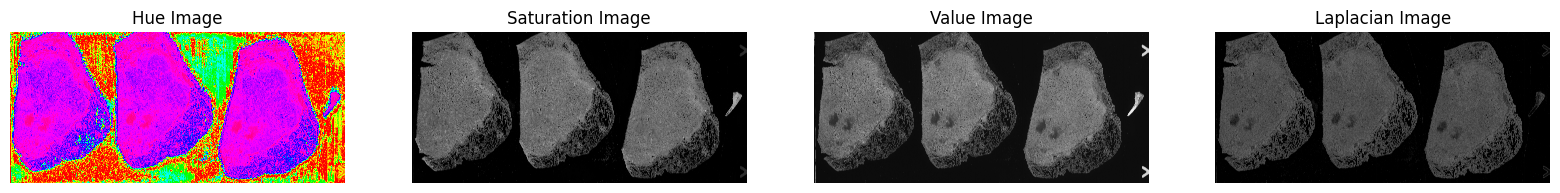

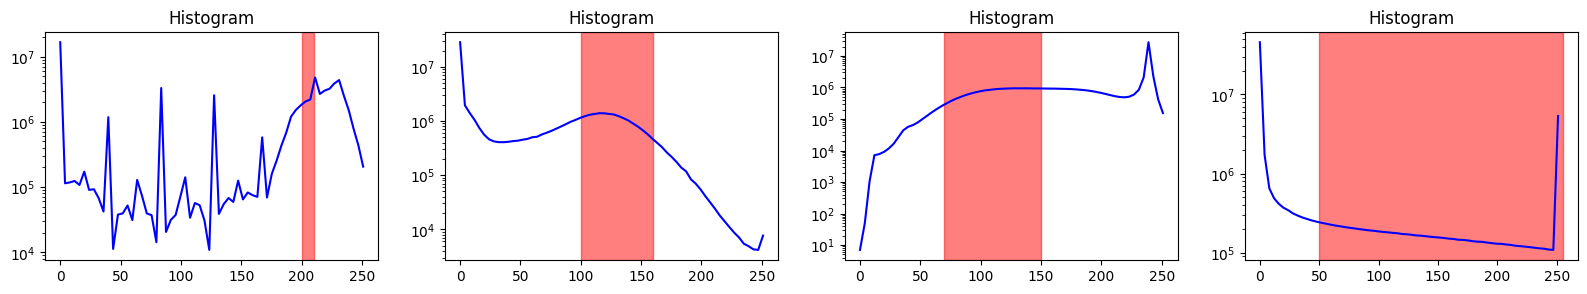

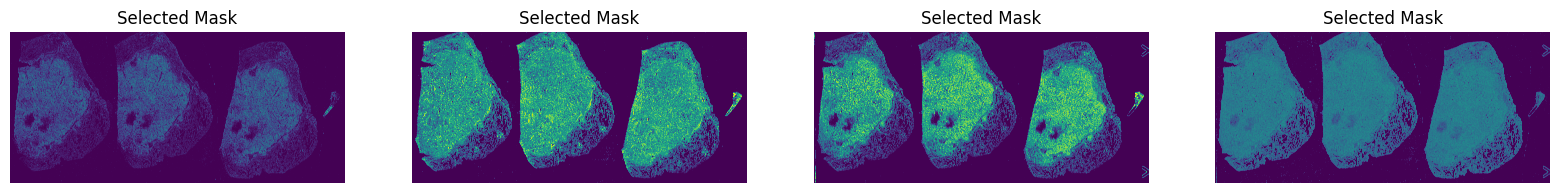

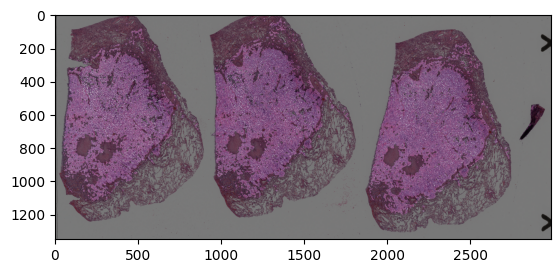

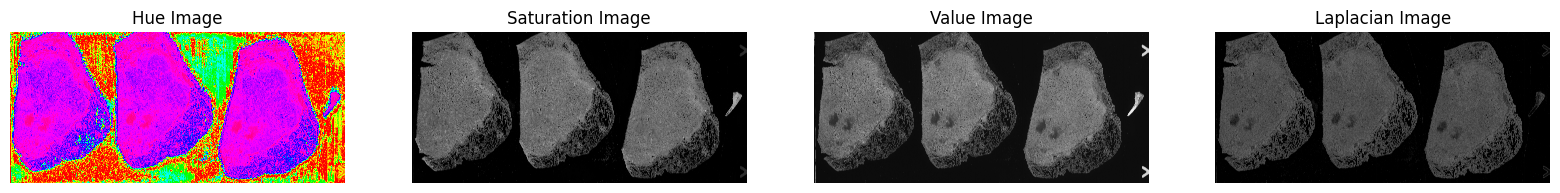

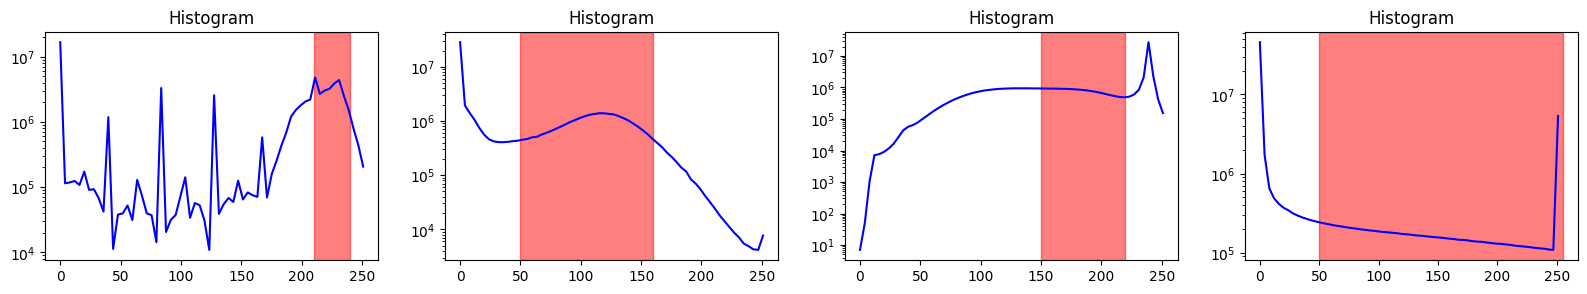

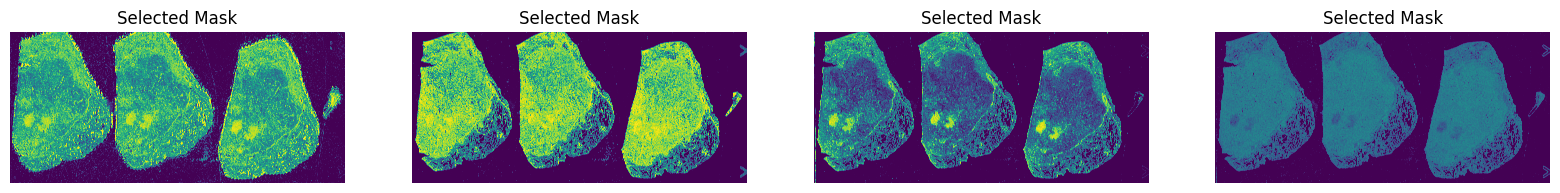

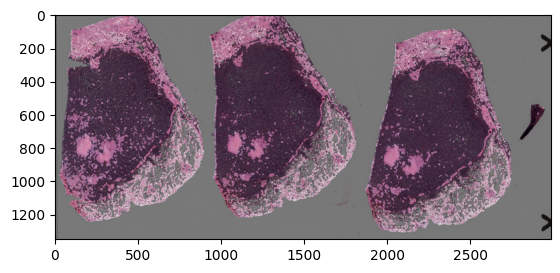

In [7]:
for num in range(len(rangeSelectList)):
    ShowSelectHistogram(hsvlDic, rangeSelectList[num])
    maskSpec = RegionMasking(hsvlDic, [rangeSelectList[num]], gauthSelect)
    ShowOverlapMask(img, maskSpec, 1/4, pathSave="test_spec_%d.png"%num)

### Union Specific Mask

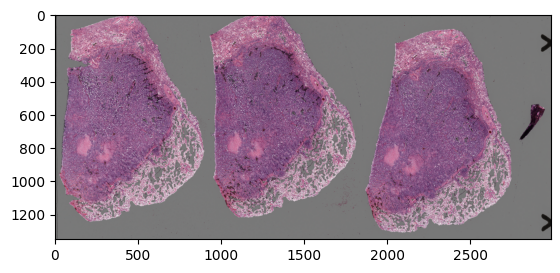

In [8]:
maskSpec = RegionMasking(img, rangeSelectList, gauthSelect)
ShowOverlapMask(img, maskSpec, 1/4, pathSave="test_spec_all.png")

### Annotation Mask

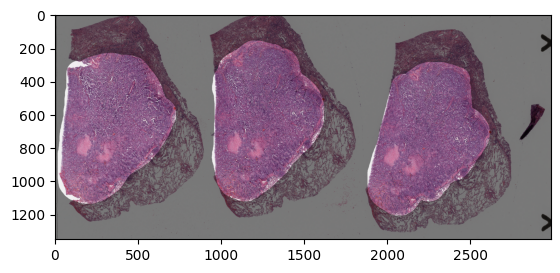

In [9]:
maskAnno = CorrdinateMasking(img.shape[:2], handleWSI.level_downsamples[2], coordinates)
ShowOverlapMask(img, maskAnno, 1/4, pathSave="test_anno.png")

### Save As bigtiff

In [10]:
SaveMaskBigtiff("test_spec.tif", maskSpec)
SaveMaskBigtiff("test_anno.tif", maskAnno)

### Patch Importer

In [11]:
patchImporter = WSIPatchImporter(pathWSI, pathSpec, pathAnno)

In [17]:
sizeMicronXY = np.array([1000, 1000])
intervalMicronXY = np.array([500, 500])
resizePixelXY = np.array([128, 128])

coordinatesPatch = patchImporter.MakePatchCoordinates(sizeMicronXY, intervalMicronXY, resizePixelXY)

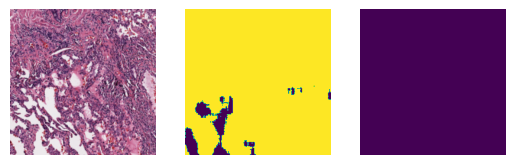

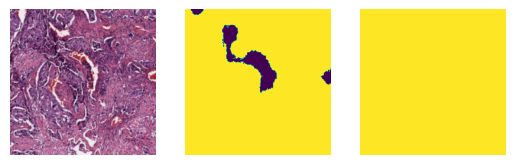

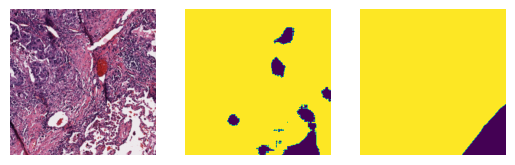

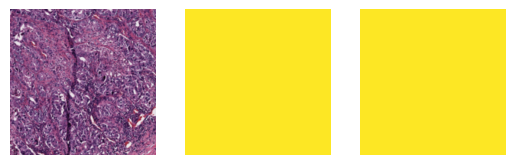

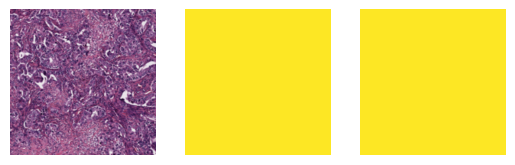

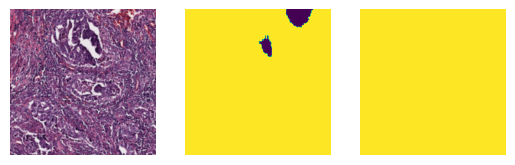

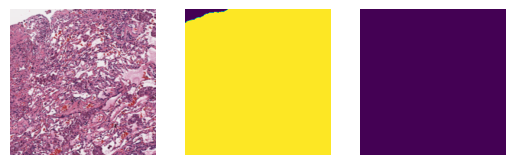

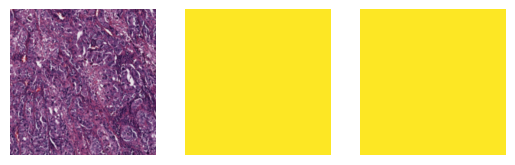

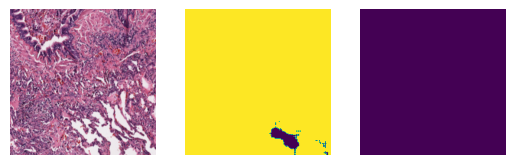

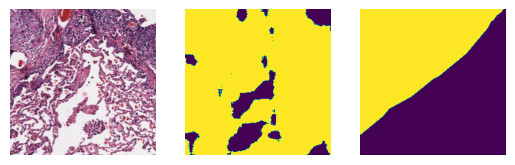

In [20]:
patchIsUseful = patchImporter.IsUsfulMask("spec", coordinatesPatch, ratioPass=0.7)

for coordinate in coordinatesPatch[patchIsUseful][:10]:
    plt.subplot(1,3,1)
    plt.imshow(patchImporter.LoadImage(coordinate))
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(patchImporter.LoadMask("spec", coordinate), vmin=0, vmax=255)
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(patchImporter.LoadMask("anno", coordinate), vmin=0, vmax=255)
    plt.axis("off")
    plt.show()